In [3]:
# [SECTION 1] LOAD DATA & CLEANING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Konfigurasi tampilan grafik agar rapi
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

file_path = "HARGA RUMAH JAKSEL.xlsx"

# 1. Logika Membaca File Excel yang Robust
try:
    # Mencoba membaca dengan asumsi header ada di baris ke-2 (index 1)
    df = pd.read_excel(file_path, header=1)

    # Validasi: Jika kolom 'HARGA' tidak ditemukan, cari secara manual
    if 'HARGA' not in df.columns:
        df_raw = pd.read_excel(file_path, header=None)
        # Cari indeks baris yang mengandung kata 'HARGA'
        header_idx = df_raw.index[df_raw.iloc[:, 0] == 'HARGA'].tolist()[0]
        df_raw.columns = df_raw.iloc[header_idx]
        df = df_raw[header_idx + 1:].reset_index(drop=True)

    print("Status: Data berhasil dimuat.")

except Exception as e:
    print(f"Status: Gagal membaca file. Error: {e}")

# 2. Pembersihan Data (Data Cleaning)
# Membersihkan spasi pada nama kolom
df.columns = df.columns.astype(str).str.strip()

# Konversi kolom ke tipe numerik
cols_numeric = ['HARGA', 'LT', 'LB', 'JKT', 'JKM']
for col in cols_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Konversi kolom Garasi (GRS) menjadi 1 (Ada) dan 0 (Tidak)
if 'GRS' in df.columns:
    df['GRS'] = df['GRS'].astype(str).apply(lambda x: 1 if 'ADA' in str(x).upper() else 0)

# Hapus baris yang memiliki nilai kosong (missing values)
df_clean = df.dropna()

print(f"Jumlah Data Bersih: {len(df_clean)} baris")
print("Sampel Data:")
display(df_clean.head())

Status: Data berhasil dimuat.
Jumlah Data Bersih: 1001 baris
Sampel Data:


,HARGA,LT,LB,JKT,JKM,GRS,KOTA
0,28000000000,1100,700,5,6,1,JAKSEL
1,19000000000,824,800,4,4,1,JAKSEL
2,4700000000,500,400,4,3,1,JAKSEL
3,4900000000,251,300,5,4,1,JAKSEL
4,28000000000,1340,575,4,5,1,JAKSEL


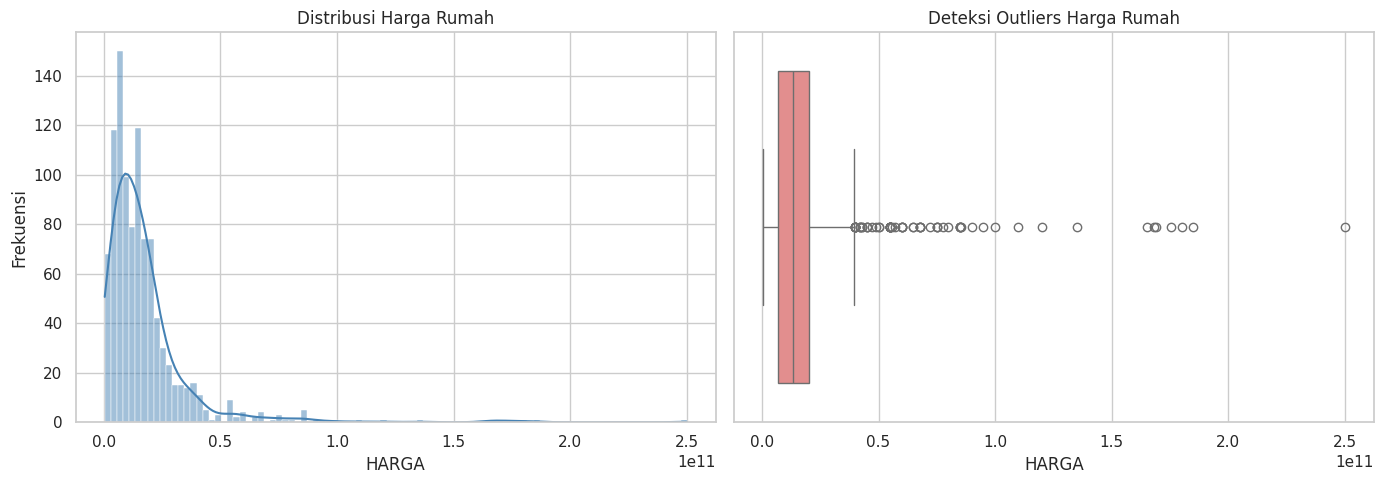

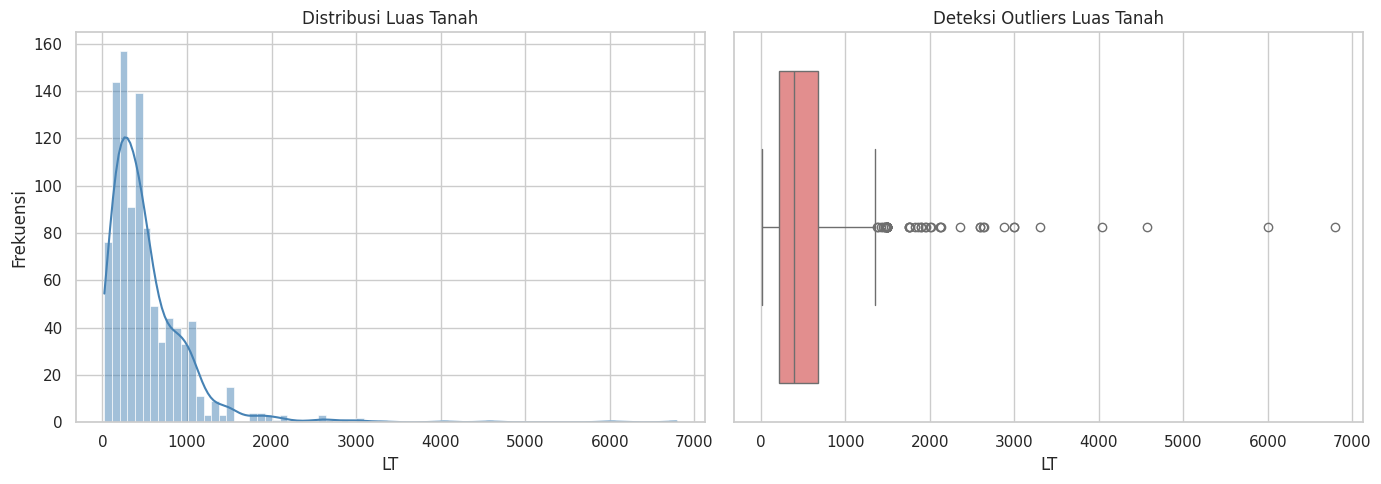

In [4]:
# [SECTION 2] VISUALISASI DATA
def plot_distribusi(data, kolom, judul):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram (Density Plot)
    sns.histplot(data[kolom], kde=True, ax=axes[0], color='steelblue')
    axes[0].set_title(f'Distribusi {judul}')
    axes[0].set_ylabel('Frekuensi')

    # Boxplot (Untuk melihat Outliers)
    sns.boxplot(x=data[kolom], ax=axes[1], color='lightcoral')
    axes[1].set_title(f'Deteksi Outliers {judul}')

    plt.tight_layout()
    plt.show()

# Menampilkan Grafik Harga dan Luas Tanah
plot_distribusi(df_clean, 'HARGA', 'Harga Rumah')
plot_distribusi(df_clean, 'LT', 'Luas Tanah')

In [5]:
# [SECTION 3] REPLIKASI MODEL JURNAL (LINEAR REGRESSION)

# Definisi Variabel Independen (X) dan Dependen (y)
X = df_clean[['LT', 'LB', 'JKT', 'JKM', 'GRS']]
y = df_clean['HARGA']

# Pembagian Data (Split) 80:20
# random_state=4 dipilih untuk mereproduksi hasil yang konsisten dengan eksperimen awal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Pelatihan Model Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Evaluasi Model
y_pred_lr = model_lr.predict(X_test)
score_lr = r2_score(y_test, y_pred_lr)

print("=== HASIL REPLIKASI JURNAL ===")
print(f"Metode: Multiple Linear Regression")
print(f"Akurasi (R2 Score): {score_lr:.4f} (atau {score_lr*100:.2f}%)")

=== HASIL REPLIKASI JURNAL ===
Metode: Multiple Linear Regression
Akurasi (R2 Score): 0.6640 (atau 66.40%)


In [6]:
# [SECTION 4] IMPROVEMENT MODEL (XGBOOST + LOG TRANSFORM)

# 1. Fungsi Penghapusan Outliers (Metode IQR)
def remove_outliers(data, cols):
    df_out = data.copy()
    for col in cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter data yang ada di dalam rentang wajar
        df_out = df_out[(df_out[col] >= lower_bound) & (df_out[col] <= upper_bound)]
    return df_out

# Terapkan pembersihan pada Harga dan Luas Tanah
df_imp = remove_outliers(df_clean, ['HARGA', 'LT', 'LB'])

# 2. Persiapan Data Baru
X_imp = df_imp[['LT', 'LB', 'JKT', 'JKM', 'GRS']]
y_imp = df_imp['HARGA']

# Split Data Baru (80:20)
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=0.2, random_state=42)

# 3. Transformasi Logaritma pada Target
y_train_log = np.log1p(y_train_imp)
y_test_log = np.log1p(y_test_imp)

# 4. Pelatihan Model Gradient Boosting
model_xgb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train_imp, y_train_log)

# 5. Prediksi dan Inverse Transform (Kembali ke Skala Rupiah Asli)
y_pred_log = model_xgb.predict(X_test_imp)
y_pred_xgb = np.expm1(y_pred_log)

# Evaluasi
score_xgb = r2_score(y_test_imp, y_pred_xgb)

print("=== HASIL IMPROVEMENT ===")
print(f"Metode: Gradient Boosting Regressor (XGBoost) + Log Transform")
print(f"Akurasi (R2 Score): {score_xgb:.4f} (atau {score_xgb*100:.2f}%)")
print(f"Peningkatan dari Jurnal: +{(score_xgb - score_lr)*100:.2f}%")

=== HASIL IMPROVEMENT ===
Metode: Gradient Boosting Regressor (XGBoost) + Log Transform
Akurasi (R2 Score): 0.7025 (atau 70.25%)
Peningkatan dari Jurnal: +3.85%


In [7]:
# [SECTION 5] STUDI KASUS DAN VALIDASI

# Spesifikasi Rumah (Sesuai Jurnal Hal. 7)
spesifikasi = pd.DataFrame([[500, 625, 5, 3, 1]],
                           columns=['LT', 'LB', 'JKT', 'JKM', 'GRS'])

# 1. Prediksi Menggunakan Model
# Model Jurnal (Linear Regression)
pred_lr = model_lr.predict(spesifikasi)[0]

# Model Improvement (XGBoost)
# Ingat: Hasil prediksi masih dalam Log, harus dikembalikan dengan expm1
pred_xgb_log = model_xgb.predict(spesifikasi)[0]
pred_xgb = np.expm1(pred_xgb_log)

# Nilai Referensi dari Jurnal
nilai_jurnal = 19486790400

# 2. Analisis Data Riil (Fakta Lapangan)
# Mengambil rata-rata harga rumah dengan Luas Tanah 500 m2 dari dataset asli
data_pembanding = df_clean[df_clean['LT'] == 500]
rata_rata_pasar = data_pembanding['HARGA'].mean()

# Menampilkan Hasil
print("SPESIFIKASI RUMAH: LT 500m2, LB 625m2, 5 KT, 3 KM")
print("-" * 50)
print(f"1. Prediksi Jurnal (Ref)  : Rp {nilai_jurnal:,.0f}")
print(f"2. Prediksi Replikasi (LR): Rp {pred_lr:,.0f}")
print(f"3. Prediksi Improve (XGB) : Rp {pred_xgb:,.0f}")
print("-" * 50)
print(f"Fakta Rata-rata Pasar     : Rp {rata_rata_pasar:,.0f}")
print("-" * 50)

# Logika Kesimpulan Otomatis
selisih_jurnal_pasar = abs(nilai_jurnal - rata_rata_pasar)
selisih_xgb_pasar = abs(pred_xgb - rata_rata_pasar)

if selisih_xgb_pasar < selisih_jurnal_pasar:
    print("KESIMPULAN: Model Improvement memberikan prediksi yang lebih realistis")
    print("dan mendekati harga pasar dibandingkan angka referensi jurnal.")

SPESIFIKASI RUMAH: LT 500m2, LB 625m2, 5 KT, 3 KM
--------------------------------------------------
1. Prediksi Jurnal (Ref)  : Rp 19,486,790,400
2. Prediksi Replikasi (LR): Rp 18,983,509,926
3. Prediksi Improve (XGB) : Rp 15,594,694,999
--------------------------------------------------
Fakta Rata-rata Pasar     : Rp 15,202,941,176
--------------------------------------------------
KESIMPULAN: Model Improvement memberikan prediksi yang lebih realistis
dan mendekati harga pasar dibandingkan angka referensi jurnal.


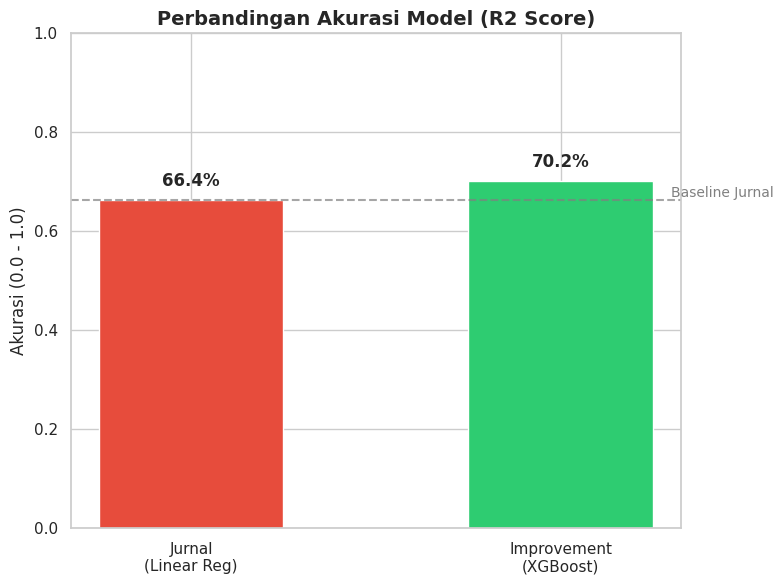

In [8]:
# [SECTION 6] GRAFIK PERBANDINGAN PERFORMA

# Data untuk visualisasi
models = ['Jurnal\n(Linear Reg)', 'Improvement\n(XGBoost)']
scores = [score_lr, score_xgb]
colors = ['#E74C3C', '#2ECC71'] # Merah untuk baseline, Hijau untuk improvement

plt.figure(figsize=(8, 6))
bars = plt.bar(models, scores, color=colors, width=0.5)

# Menambahkan garis batas baseline jurnal
plt.axhline(y=score_lr, color='gray', linestyle='--', alpha=0.7)
plt.text(1.3, score_lr, 'Baseline Jurnal', va='bottom', fontsize=10, color='gray')

plt.ylim(0, 1.0)
plt.title('Perbandingan Akurasi Model (R2 Score)', fontsize=14, fontweight='bold')
plt.ylabel('Akurasi (0.0 - 1.0)', fontsize=12)

# Menambahkan label angka di atas batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02,
             f'{height*100:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()